In [244]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
import neurogym as ngym
import torch.optim as optim

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


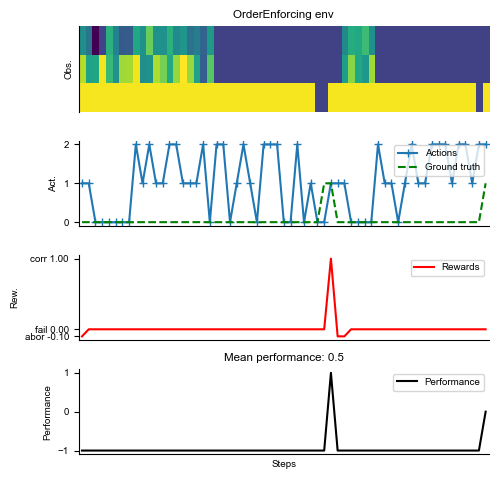

In [245]:


# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
dt=20
hidden_size=64
batch_size=16
seq_len=100

kwargs={'dt': dt, 'timing': timing}

dataset = ngym.Dataset(
    task, kwargs, batch_size=batch_size,
    seq_len=seq_len)
env = dataset.env
act_size = env.action_space.n


# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [246]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones(hidden_size, hidden_size) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        E_I_unit_list = np.concatenate((np.ones(self.e_size), -np.ones(self.i_size)))

        E_I_matrix = np.diag(E_I_unit_list)

        mask = mask_no_diag @ E_I_matrix


        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

In [247]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 35
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [248]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

C:\Users\guyda\AppData\Local\Temp\ipykernel_33412\337671595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=51, out_features=3, bias=True)
)
Step 100, Loss 0.6521
Step 200, Loss 0.3458
Step 300, Loss 0.3375
Step 400, Loss 0.3221
Step 500, Loss 0.3031
Step 600, Loss 0.3090
Step 700, Loss 0.2916
Step 800, Loss 0.2954
Step 900, Loss 0.2952
Step 1000, Loss 0.2875
Step 1100, Loss 0.2814
Step 1200, Loss 0.2858
Step 1300, Loss 0.2786
Step 1400, Loss 0.2853
Step 1500, Loss 0.2833
Step 1600, Loss 0.2742
Step 1700, Loss 0.2724
Step 1800, Loss 0.2795
Step 1900, Loss 0.2771
Step 2000, Loss 0.2758


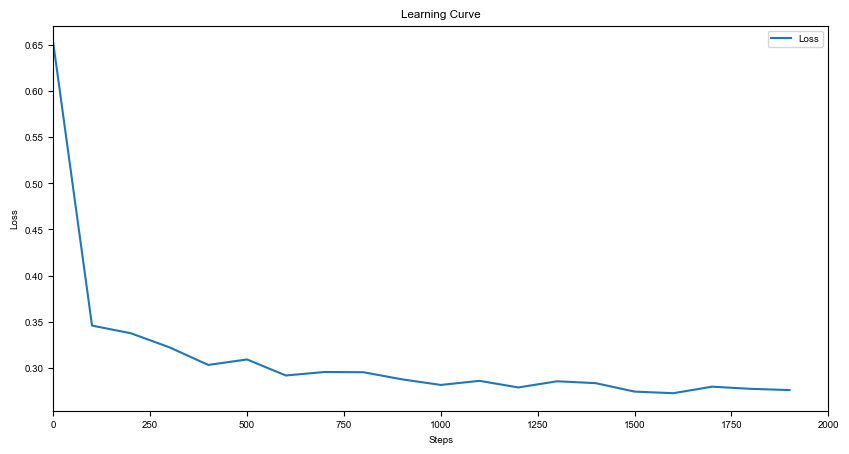

In [249]:
hidden_size = 64
e_prop=0.5

net = Net(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 100
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
steps = np.arange(0, 2000, print_step)
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(steps,loss_values, label='Loss')
plt.xlabel("Steps")
plt.xlim(0,2000)
plt.ylabel("Loss")
plt.legend()
plt.show()

np.save('./npArrays/EILoss.npy', loss_values)

In [250]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

In [252]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
env.timing = infer_test_timing(env)
print(env.timing)
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['decision']]
    #stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

{'fixation': 500.0, 'stimulus': 500.0, 'delay': 1200.0, 'decision': 1500.0}
Average performance 0.472


51


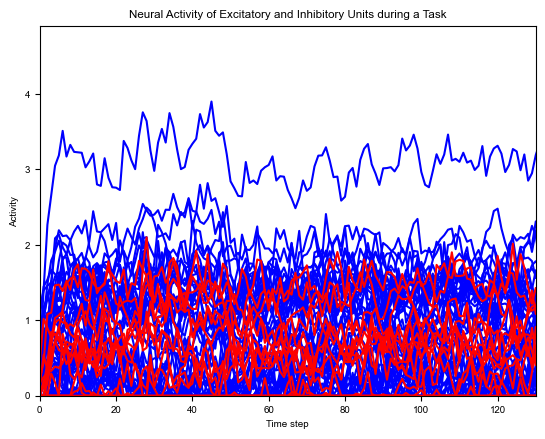

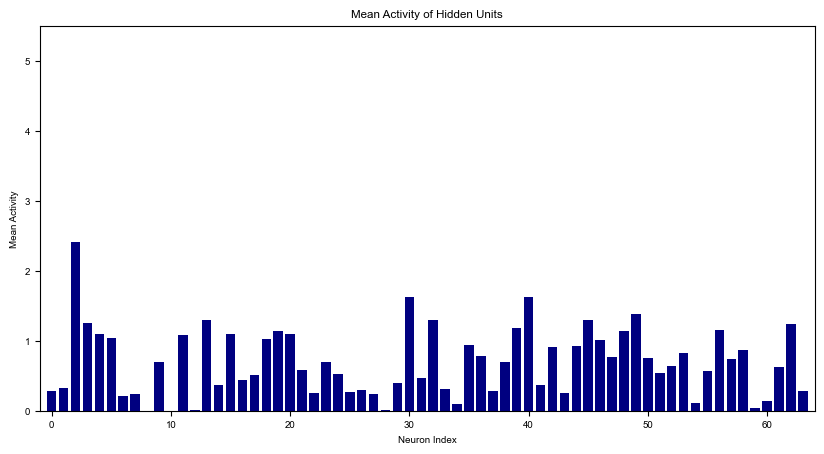

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
e_size = net.rnn.e_size
trial = 450
print(e_size)
plt.figure()
plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.title('Neural Activity of Excitatory and Inhibitory Units during a Task')
plt.ylim(0,np.max(activity_dict[trial]+1))
plt.xlim(0,130)
plt.savefig('./figs/EIneuralactivity.png')

def plot_activity(activity, threshold=0.1):
    """
    Plots the activity of the neural network's activity.

    Parameters:
    activity (numpy.ndarray): Neural activity array of shape (time_steps, hidden_size).
    threshold (float): Threshold below which activity is considered sparse.
    """
    activity = np.mean(np.abs(activity), axis=0)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(activity)), activity,color='brown')
    plt.xlabel('Neuron Index')
    plt.ylabel('Mean Activity')
    plt.ylim(0,5.5)
    plt.xlim(-1,hidden_size)
    plt.title('Neural Network Activity')
    plt.show()
plot_activity(activity_dict[trial])

{'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 1, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 2}
{'ground_truth': 2, 'coh': 51.2, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 2, 'coh': 12.8, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 1, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': True, 'choice': 1}
{'ground_truth': 2, 'coh': 0.0, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 2, 'coh': 6.4, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
{'ground_truth': 2, 'coh': 51.2, 'sigma': 0.22360679774997896, 'correct': False, 'choice': 1}
Shape of the neural activity (Time points, Neurons): (102120, 64)
S

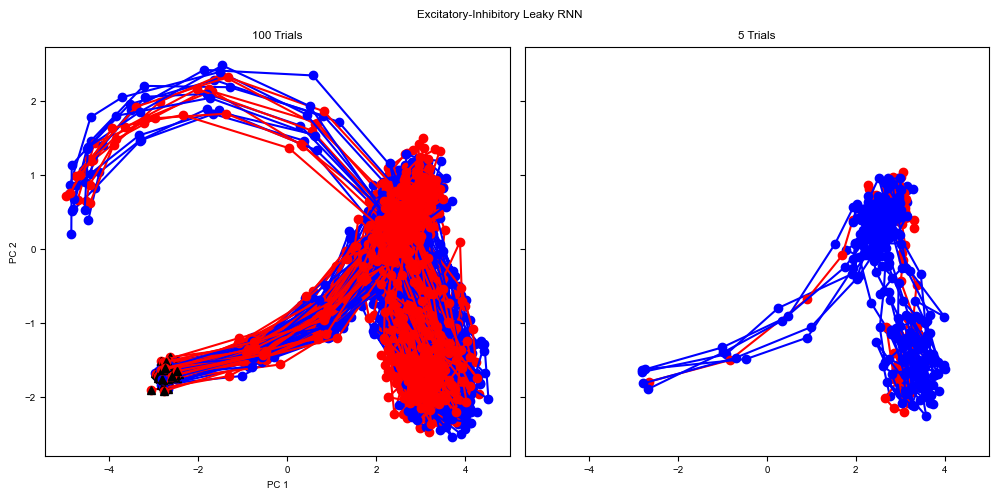

In [259]:
from sklearn.decomposition import PCA
num_trial = len(activity_dict)  
### Play with different values here to understand the dynamics
plot_until_time = 70

for i in range(10):
    print(trial_infos[i])


# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)


# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)

print('Shape of the projected activity for standard leaky RNN (Time points, PCs):', activity_pc.shape)


# Visualization
import matplotlib.pyplot as plt

def plot_trials(activity_dict, trial_infos, plot_until_time, title, ax1_title, ax2_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

    # Plot all trials in ax1 and fewer trials in ax2 for clarity
    for i in range(100):
        # Transform and plot each trial
        activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

        # Color by ground truth
        trial = trial_infos[i]
        color = 'red' if trial['ground_truth'] == 1 else 'blue'

        ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        if i < 6:  # Fewer trials in ax2 for clear visualization
            ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

        # Indicate trial start with a different marker
        ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

    # Setting labels and titles for clarity
    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)
    ax1.set_xlabel('PC 1')
    ax1.set_ylabel('PC 2')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Plot for standard leaky RNN
plot_trials(activity_dict=activity_dict, trial_infos=trial_infos, plot_until_time=plot_until_time,
    title="Excitatory-Inhibitory Leaky RNN", ax1_title="100 Trials", ax2_title="5 Trials")


In [260]:
import sys
sys.path.append('./fixed-point-finder')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, (hidden, hidden))

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden[0].unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 8.79e-01 +/- 1.63e-01
		dq = 8.38e-02 +/- 8.09e-02
		learning rate = 1.97e-07
		avg iter time = 8.39e-04 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



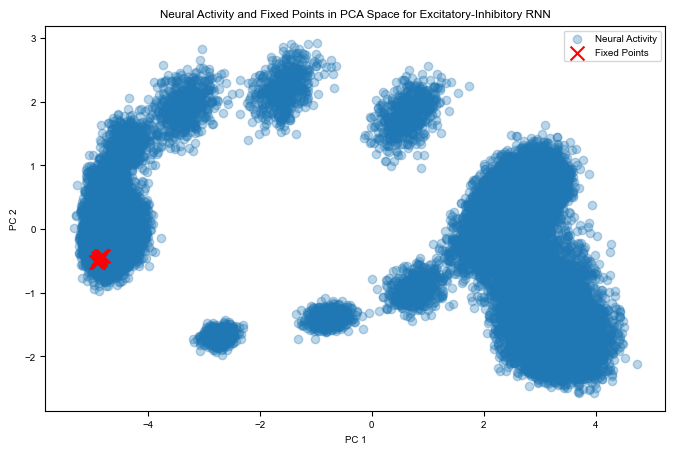

In [261]:
# Instantiate the FixedPointRNNWrapper with the model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)


# Instantiate FixedPointFinder with the wrapped models
finder = FixedPointFinder(rnn_model_fixed_point)



# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
inputs = torch.zeros(10, net.rnn.input_size)  # Zero input for each initial condition


# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Find fixed points (Check FixedPointFinder documentation)
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)


# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]activity_list = []


# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]


pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)

pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)

fixed_points_pc = pca.transform(fixed_points_array)


# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space for Excitatory-Inhibitory RNN")
plt.legend()
plt.show()# Plot activity and fixed points




51


Text(0.5, 1.0, 'Network connectivity')

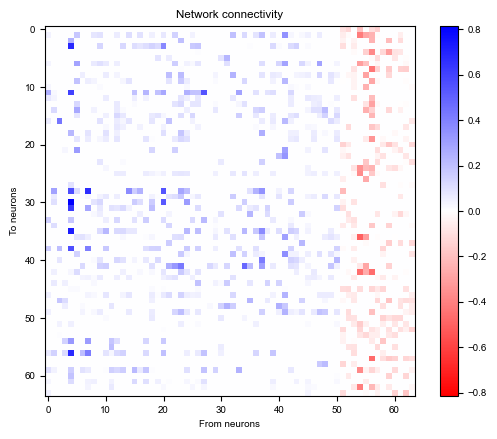

In [ ]:
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    #activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)
print(e_size)
# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')